### Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian (see paper), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz Spectral Density, commonly used with the HEOM. We show how to do the Matsubara and Pade analytical decompositions, as well as how to fit the latter with a finite set of approximate exponentials.  

### Drude-Lorentz spectral density
The Drude-Lorentz spectral density is:

$$J(\omega)=\omega \frac{2\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off frequency.

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

The Matsubara decomposition of the Drude-Lorentz spectral density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta \hbar}  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i) / \hbar               & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \hbar^2 \}    & k \geq 1\\
           \end{cases}
\end{equation*}



In [1]:
%pylab inline
from qutip import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip.ipynbtools import HTMLProgressBar

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from heom.pyheom import BosonicHEOMSolver

In [5]:

def cot(x):
    return 1./np.tan(x)

### Here we set $H_{sys}=0$, which means the interaction Hamiltonian and the system Hamiltonian commute, and we can compare the numerical results to a known analytical one.

In [7]:
# Defining the system Hamiltonian
eps = 0.     # Energy of the 2-level system.
Del = 0.    # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del* sigmax()

In [8]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz() # coupling operator

tlist = np.linspace(0, 50, 1000)

#Bath properties:
gamma = .5 # cut off frequency
#gamma = 0.1
lam = .1 # coupling strenght
T = .5
beta = 1./T
#HEOM parameters

NC = 6 # cut off parameter for the bath

In [9]:


Nk = 3 # number of exponentials in approximation of the the spectral density

pref = 1.

ckAR = [pref * lam * gamma * (cot(gamma / (2 * T))) + 0.j]
ckAR.extend([(pref * 4 * lam * gamma * T *  2 * np.pi * k * T / (( 2 * np.pi * k * T)**2 - gamma**2))+0.j for k in range(1,Nk)])

vkAR = [gamma+0.j]
vkAR.extend([2 * np.pi * k * T + 0.j for k in range(1,Nk)])

ckAI = [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]

print(ckAR)
print(ckAI)

print(vkAR)
print(vkAI)




[(0.0915243860856226+0j), (0.032658231280633825+0j), (0.016016922656808007+0j)]
[(-0.05+0j)]
[(0.5+0j), (3.141592653589793+0j), (6.283185307179586+0j)]
[(0.5+0j)]


In [10]:

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

HEOMMats = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)


[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


## To get a non-trivial result we prepare the initial state in a superposition, and see how the bath destroys the coherence

In [11]:
# Initial state of the system.

psi = (basis(2,0) + basis(2,1))/sqrt(2)

rho0 = psi * psi.dag()


resultMats = HEOMMats.run(rho0, tlist)


In [12]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11exp = expect(resultMats.states, P11p)
P22exp = expect(resultMats.states, P22p)
P12exp = expect(resultMats.states, P12p)

In [13]:
#do version with tanimura terminator

op = -2*spre(Q)*spost(Q.dag()) + spre(Q.dag()*Q) + spost(Q.dag()*Q)

approx_factr = ((2 * lam / (beta * gamma)) - 1j*lam) 

approx_factr -=  lam * gamma * (-1.0j + cot(gamma / (2 * T)))/gamma
for k in range(1,Nk):
    vk = 2 * np.pi * k * T
    #c_temp.append((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
    approx_factr -= ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))/ vk)
    #approx_factr -= (c[k] / nu[k])
L_bnd = -approx_factr*op

Ltot = -1.0j*(spre(Hsys)-spost(Hsys)) + L_bnd
Ltot = liouvillian(Hsys) + L_bnd

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

HEOMMatsT = BosonicHEOMSolver(Ltot, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)

resultMatsT = HEOMMatsT.run(rho0, tlist)


[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


In [14]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expT = expect(resultMatsT.states, P11p)
P22expT = expect(resultMatsT.states, P22p)
P12expT = expect(resultMatsT.states, P12p)

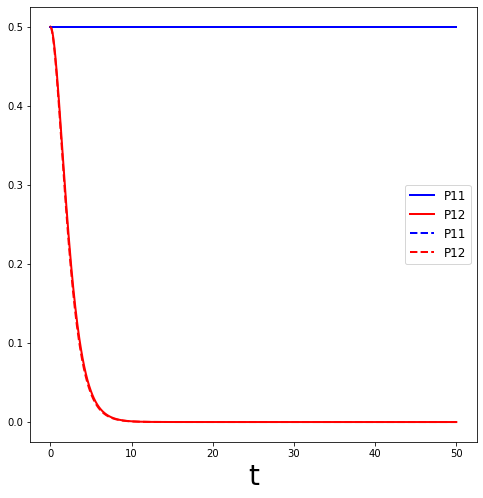

In [15]:

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(tlist, np.real(P11exp)+ np.real(P22exp), 'b', linewidth=2, label="P11")
axes.plot(tlist, np.real(P11exp), 'b', linewidth=2, label="P11")
axes.plot(tlist, np.real(P12exp), 'r', linewidth=2, label="P12")
axes.plot(tlist, np.real(P11expT), 'b--', linewidth=2, label="P11")
axes.plot(tlist, np.real(P12expT), 'r--', linewidth=2, label="P12")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

In [16]:

#as a comparison, this is pade


lmax = 3



def deltafun(j,k):
    if j==k: 
        return 1.
    else:
        return 0.




Alpha =np.zeros((2*lmax,2*lmax))
for j in range(2*lmax):
    for k in range(2*lmax):
        #Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)-1)*(2*(k+1)-1)) #fermi
        Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1)) #bose
        
eigvalsA=eigvalsh(Alpha)  

eps = []
for val in  eigvalsA[0:lmax]:
    #print(-2/val)
    eps.append(-2/val)
    

AlphaP =np.zeros((2*lmax-1,2*lmax-1))
for j in range(2*lmax-1):
    for k in range(2*lmax-1):
        #AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1)) #fermi
        
        AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+3)*(2*(k+1)+3)) #Bos: This is +3 because +1 (bose) + 2*(+1)(from bm+1)
        
eigvalsAP=eigvalsh(AlphaP)    


chi = []
for val in  eigvalsAP[0:lmax-1]:
    #print(-2/val)
    chi.append(-2/val)

eta_list = []
prefactor = 0.5*lmax*(2*(lmax + 1) - 1)

for j in range(lmax):
    term = prefactor
    for k1 in range(lmax - 1):
        term *= (chi[k1]**2 - eps[j]**2)/(eps[k1]**2 - eps[j]**2 + deltafun(j,k1))        
    #term2 = 1
    for k2 in range(lmax-1,lmax):
        term /= (eps[k2]**2 - eps[j]**2 + deltafun(j,k2))
        #print(term2)
        
    eta_list.append(term)

kappa = [0]+eta_list

epsilon = [0]+eps



beta = 1/T

def f_approx(x):
    f = 0.5
    for l in range(1,lmax+1):
        f= f - 2*kappa[l]*x/(x**2+epsilon[l]**2)
    return f

def f(x):
    kB=1.
    return 1/(1-exp(-x)) #this is n(w)+1  btw! (for bosons)


def C(tlist):
    eta_list = []
    gamma_list  =[]
    
   
    eta_0 =lam*gamma*(1.0/np.tan(gamma*beta/2.0) - 1.0j)
    gamma_0 = gamma
    eta_list.append(eta_0)
    gamma_list.append(gamma_0)
    if lmax>0:
        for l in range(1,lmax+1):
            eta_list.append((kappa[l]/beta)*4*lam*gamma*(epsilon[l]/beta)/((epsilon[l]**2/beta**2)-gamma**2))
            gamma_list.append(epsilon[l]/beta)
            
     
    c_tot = []
    for t in tlist:
        c_tot.append(sum([eta_list[l]*exp(-gamma_list[l]*t) for l in range(lmax+1)]))
    return c_tot, eta_list, gamma_list


cppLP,etapLP,gampLP = C(tlist)




In [17]:

ckAR = [real(eta) +0j for eta in etapLP]
ckAI = [imag(etapLP[0]) + 0j]

In [18]:
vkAR = [gam +0j for gam in gampLP]
vkAI = [gampLP[0] + 0j]


In [19]:


NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

HEOMPade = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)



resultPade = HEOMPade.run(rho0, tlist)

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


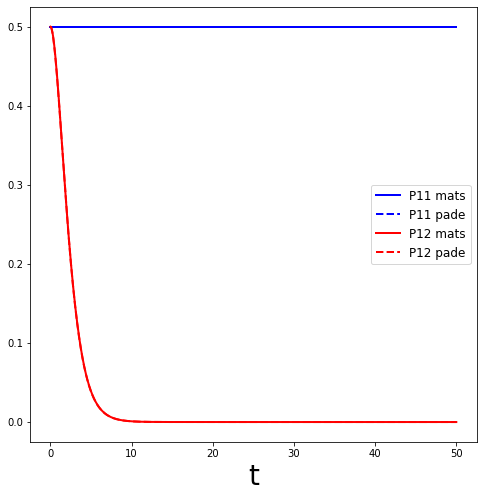

In [20]:

#10
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expP = expect(resultPade.states, P11p)
P22expP = expect(resultPade.states, P22p)
P12expP = expect(resultPade.states, P12p)

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(tlist, np.real(P11exp)+ np.real(P22exp), 'b', linewidth=2, label="P11")
axes.plot(tlist, np.real(P11exp), 'b', linewidth=2, label="P11 mats")
axes.plot(tlist, np.real(P11expP), 'b--', linewidth=2, label="P11 pade")
axes.plot(tlist, np.real(P12exp), 'r', linewidth=2, label="P12 mats")
axes.plot(tlist, np.real(P12expP), 'r--', linewidth=2, label="P12 pade")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

### Do fitting of expansion



In [21]:

tlist2= linspace(0,2,10000)


lmaxmats = 15000

def c(t,anamax):

    c_temp = (pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))
    for k in range(1, anamax):
        vk = 2 * np.pi * k * T
        c_temp += ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
        
    
    return c_temp

# Reals parts
corrRana = [np.real(c(t,lmaxmats)) for t in tlist2]
# Imaginary parts
corrIana = [np.imag((pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))) for t in tlist2]



1
2
3
4


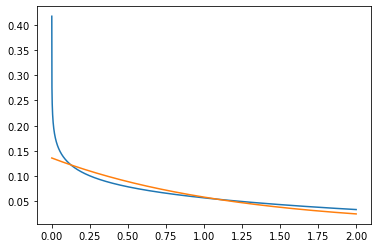

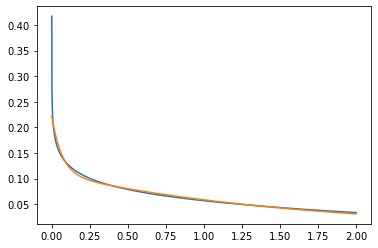

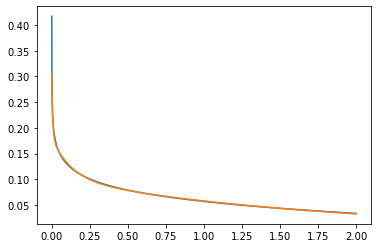

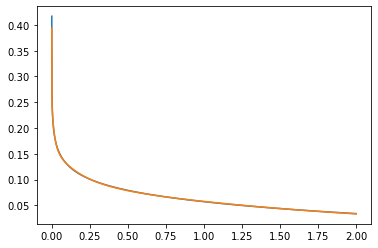

1


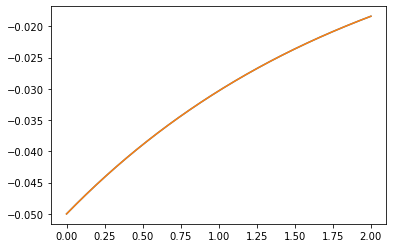

In [22]:


from scipy.optimize import curve_fit
def wrapper_fit_func(x, N, *args):
    a, b = list(args[0][:N]), list(args[0][N:2*N])
    # print("debug")
    return fit_func(x, a, b, N)

# actual fitting function
def fit_func(x, a, b, N):
    tot = 0
    for i in range(N):
        # print(i)
        tot += a[i]*np.exp(b[i]*x)
    return tot


def fitter(ans, tlist, k):
    # the actual computing of fit
    popt = []
    pcov = [] 
    # tries to fit for k exponents
    for i in range(k):
        params_0 = [0]*(2*(i+1))
        upper_a = abs(max(ans, key = abs))*10
        #sets initial guess
        guess = []
        aguess = [ans[0]]*(i+1)#[max(ans)]*(i+1)
        bguess = [0]*(i+1)
        guess.extend(aguess)
        guess.extend(bguess)
        # sets bounds
        # a's = anything , b's negative
        # sets lower bound
        b_lower = []
        alower = [-upper_a]*(i+1)
        blower = [-np.inf]*(i+1)
        b_lower.extend(alower)
        b_lower.extend(blower)
        # sets higher bound
        b_higher = []
        ahigher = [upper_a]*(i+1)
        bhigher = [0]*(i+1)
        b_higher.extend(ahigher)
        b_higher.extend(bhigher)
        param_bounds = (b_lower, b_higher)
        p1, p2 = curve_fit(lambda x, *params_0: wrapper_fit_func(x, i+1, \
            params_0), tlist, ans, p0=guess, sigma=[0.01 for t in tlist2], bounds = param_bounds,maxfev = 1e8)
        popt.append(p1)
        pcov.append(p2)
        print(i+1)
    return popt
# print(popt)

# function that evaluates values with fitted params at
# given inputs
def checker(tlist, vals):
    y = []
    for i in tlist:
        # print(i)
        y.append(wrapper_fit_func(i, int(len(vals)/2), vals))
    return y

k = 4
popt1 = fitter(corrRana, tlist2, k)
for i in range(k):
    y = checker(tlist2, popt1[i])
    plt.plot(tlist2, corrRana, tlist2, y)
    plt.show()

k1 = 1
popt2 = fitter(corrIana, tlist2, k1)
for i in range(k1):
    y = checker(tlist2, popt2[i])
    plt.plot(tlist2, corrIana, tlist2, y)
    plt.show()  


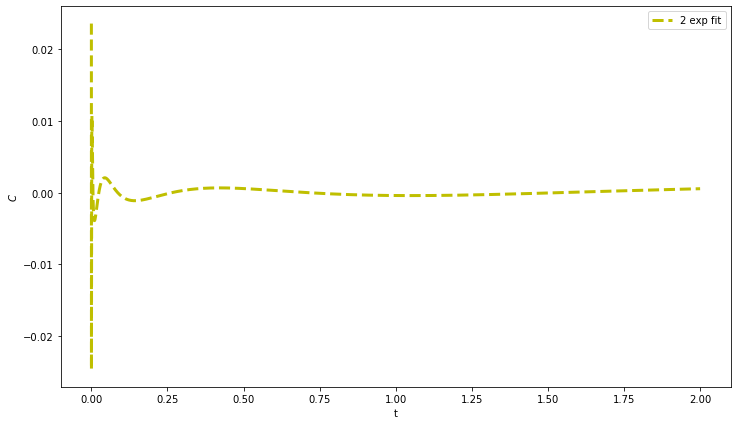

In [23]:

fig, ax1 = plt.subplots(figsize=(12, 7))
#print(gam_list)

y = checker(tlist2, popt1[-1])

    
    
#ax1.plot(tlist,corrRana-real(cppLP), color="b", linewidth=3, label= r"real pade 7")

#ax1.plot(tlist,corrRana, "r--", linewidth=3, label= r"real mats 15000")
#ax1.plot(tlist,corrRana-real(cppL), "g--", linewidth=3, label= r"real mats 5")
ax1.plot(tlist2,corrRana-real(y), "y--", linewidth=3, label= r"2 exp fit")
#ax1.plot(tlist,corrIana, "r--", linewidth=3, label= r"imag ana")


    
#ax1.plot(tlist,corrIana-real(y), color="r", linewidth=3, label= r"imag pade 7")

ax1.set_xlabel("t")
ax1.set_ylabel(r"$C$")
ax1.legend()





In [24]:
ckAR1 = list(popt1[k-1])[:len(list(popt1[k-1]))//2]
ckAR = [x+0j for x in ckAR1]
ckAI1 = list(popt2[k1-1])[:len(list(popt2[k1-1]))//2]
#minus?wtfiforgotagain
ckAI = [x+0j for x in ckAI1]
# vkAR, vkAI
vkAR1 = list(popt1[k-1])[len(list(popt1[k-1]))//2:]
vkAR = [-x+0j for x in vkAR1]
vkAI1 = list(popt2[k1-1])[len(list(popt2[k1-1]))//2:]
vkAI = [-x+0j for x in vkAI1]
# NC, NR, NI
# print(np.array(H).shape, np.array(Q).shape)
NC = 8
NR = len(ckAR)
NI = len(ckAI)

options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)


In [25]:
#overwrite imaginary fit with analytical value jsut in case

ckAI = [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]
print(ckAI)
print(vkAI)

[(-0.05+0j)]
[(0.5+0j)]


In [26]:



NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

HEOMFit = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)


[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


In [27]:


resultFit = HEOMFit.run(rho0, tlist)

In [28]:



#do version with tanimura terminator

op = -2*spre(Q)*spost(Q.dag()) + spre(Q.dag()*Q) + spost(Q.dag()*Q)

approx_factr = ((2 * lam / (beta * gamma)) - 1j*lam) 

approx_factr -=  lam * gamma * (-1.0j + cot(gamma / (2 * T)))/gamma

for k in range(1,lmaxmats):
    vk = 2 * np.pi * k * T
    #c_temp.append((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
    approx_factr -= ((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))/ vk)
    #approx_factr -= (c[k] / nu[k])
    
print(approx_factr)
L_bnd = -approx_factr*op
print(approx_factr)
Ltot = -1.0j*(spre(Hsys)-spost(Hsys)) + L_bnd
#Ltot = liouvillian(Hsys) + L_bnd

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)


NC= 10
HEOMFitT = BosonicHEOMSolver(Ltot, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)



#resultFitTL5k2 = HEOMFitT.run(rho0, tlist)
resultFitT = HEOMFitT.run(rho0, tlist)

# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expFT = expect(resultFitT.states, P11p)
P22expFT = expect(resultFitT.states, P22p)
P12expFT = expect(resultFitT.states, P12p)



(6.754970739519044e-07+0j)
(6.754970739519044e-07+0j)
[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]


In [29]:
# qsave(resultMats, 'resultMatsPD')
# qsave(resultMatsT, 'resultMatsTPD')
# qsave(resultPade, 'resultPadePD')
# #these are lmaxmats = 1e5
# qsave(resultFit, 'resultFitPD')
# qsave(resultFitT, 'resultFitTPD')

In [30]:
# qsave(resultFit, 'resultFitPD1e7')
# qsave(resultFitT, 'resultFitTPD1e7')

In [31]:
print(Hsys.eigenstates())
energies, states = Hsys.eigenstates()

(array([-0.,  0.]), array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-1.]
 [ 0.]],
       Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]], dtype=object))


In [32]:
print(Hsys.eigenstates())
energies, states = Hsys.eigenstates()
rhoss = (states[0]*states[0].dag()*exp(-beta*energies[0]) + states[1]*states[1].dag()*exp(-beta*energies[1]))
rhoss = rhoss/rhoss.norm()

P12 = expect(rhoss,P12p)

(array([-0.,  0.]), array([Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-1.]
 [ 0.]],
       Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]], dtype=object))


In [33]:
def pure_dephasing_evolution_analytical(tlist, wq, ck, vk):
    """
    Computes the propagating function appearing in the pure dephasing model.
        
    Parameters
    ----------
    t: float
        A float specifying the time at which to calculate the integral.
    
    wq: float
        The qubit frequency in the Hamiltonian.

    ck: ndarray
        The list of coefficients in the correlation function.
        
    vk: ndarray
        The list of frequencies in the correlation function.
    
    Returns
    -------
    integral: float
        The value of the integral function at time t.
    """
    evolution = np.array([np.exp(-1j*wq*t - correlation_integral(t, ck, vk)) for t in tlist])
    return evolution

def correlation_integral(t, ck, vk):
    """
    Computes the integral sum function appearing in the pure dephasing model.
    
    If the correlation function is a sum of exponentials then this sum
    is given by:
    
    .. math:
        
        \int_0^{t}d\tau D(\tau) = \sum_k\frac{c_k}{\mu_k^2}e^{\mu_k t}
        + \frac{\bar c_k}{\bar \mu_k^2}e^{\bar \mu_k t}
        - \frac{\bar \mu_k c_k + \mu_k \bar c_k}{\mu_k \bar \mu_k} t
        + \frac{\bar \mu_k^2 c_k + \mu_k^2 \bar c_k}{\mu_k^2 \bar \mu_k^2}
        
    Parameters
    ----------
    t: float
        A float specifying the time at which to calculate the integral.
    
    ck: ndarray
        The list of coefficients in the correlation function.
        
    vk: ndarray
        The list of frequencies in the correlation function.
    
    Returns
    -------
    integral: float
        The value of the integral function at time t.
    """
    t1 = np.sum(np.multiply(np.divide(ck, vk**2), np.exp(vk*t) - 1))
    
    t2 = np.sum(np.multiply(np.divide(np.conjugate(ck), np.conjugate(vk)**2),
                            np.exp(np.conjugate(vk)*t) - 1))
    t3 = np.sum((np.divide(ck, vk) + np.divide(np.conjugate(ck), np.conjugate(vk)))*t)

    return 2*(t1+t2-t3)

In [34]:

lmaxmats2 =  15000



ck = [pref * lam * gamma * (cot(gamma / (2 * T))) + pref * lam * gamma * (-1.0) * 1.j]
ck.extend([(pref * 4 * lam * gamma * T *  2 * np.pi * k * T / (( 2 * np.pi * k * T)**2 - gamma**2))+0.j for k in range(1,lmaxmats2)])

vk = [-gamma]
vk.extend([-2 * np.pi * k * T + 0.j for k in range(1,lmaxmats2)])

PEG_DL2 = 0.5*pure_dephasing_evolution_analytical(tlist, 0, asarray(ck), asarray(vk))

In [35]:
import scipy as sp

In [36]:
coth = lambda x: 1/np.tanh(x)

def JDL(omega,lamc,omega_c):
    
    return 2.*lamc*omega*omega_c/((omega_c**2)+omega**2)

def integrand(omega,lamc,omega_c,Temp,t):
   
    return (-4.*JDL(omega,lamc,omega_c)/omega**2)*(1.-np.cos(omega*t))*(coth(omega/(2.*Temp)))/pi

PEG_DL= [0.5*np.exp(sp.integrate.quad(integrand,0.0,np.inf,args=(lam,gamma,T,t,)))[0] for t in tlist]
#note to compare to the heom we have to divide lamo0h by pi. this is because ishizaki/tanimura assume C(t) = 1/pi int(J(w) etc)
# see J. Chem. Phys. 130, 234111 and PRL 104, 250401 (2010)

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  # This is added back by InteractiveShellApp.init_path()


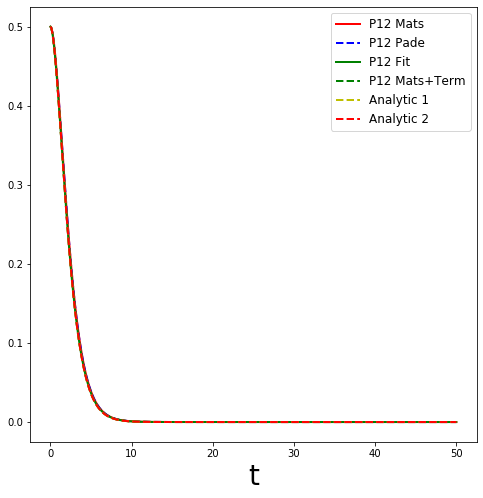

In [37]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expF = expect(resultFit.states, P11p)
P22expF = expect(resultFit.states, P22p)
P12expF = expect(resultFit.states, P12p)

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))


axes.plot(tlist, np.real(P12exp), 'r', linewidth=2, label="P12 Mats")
axes.plot(tlist, np.real(P12expP), 'b--', linewidth=2, label="P12 Pade")
axes.plot(tlist, np.real(P12expF), 'g', linewidth=2, label="P12 Fit")

axes.plot(tlist, np.real(P12expT), 'g--', linewidth=2, label="P12 Mats+Term")

axes.plot(tlist, np.real(PEG_DL), 'y--', linewidth=2, label="Analytic 1")
axes.plot(tlist, np.real(PEG_DL2), 'r--', linewidth=2, label="Analytic 2")

axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)


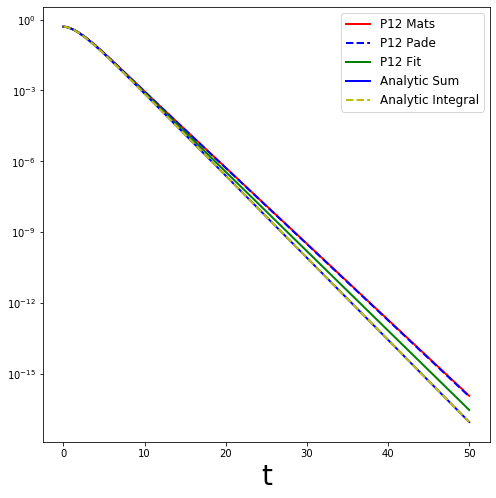

In [38]:

#small gamma


# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11expF = expect(resultFit.states, P11p)
P22expF = expect(resultFit.states, P22p)
P12expF = expect(resultFit.states, P12p)

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

axes.semilogy(tlist, np.real(P12exp), 'r', linewidth=2, label="P12 Mats")
axes.semilogy(tlist, np.real(P12expP), 'b--', linewidth=2, label="P12 Pade")
axes.semilogy(tlist, np.real(P12expF), 'g', linewidth=2, label="P12 Fit")
#axes.plot(tlist, np.real(P12expFT), 'y--', linewidth=2, label="P12 Fit + term")

#axes.plot(tlist, np.real(P11expT), 'g--', linewidth=2, label="P11 Mats+Term")
#axes.plot(tlist, np.real(P12expT), 'g', linewidth=2, label="P12 Mats+Term")

axes.semilogy(tlist, np.real(PEG_DL), 'b', linewidth=2, label="Analytic Sum")
axes.semilogy(tlist, np.real(PEG_DL2), 'y--',linewidth=2, label="Analytic Integral")
#axes.plot(tlist, [np.real(P12) for t in tlist], 'g--', linewidth=2, label="P12 thermal")

#axes.plot(tlist, [np.real(P11RC) for t in tlist], 'g--', linewidth=2, label="P12 thermal")
#axes.set_ylim(0.0,0.05)
#axes.set_xlim(0,20)
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)